In [1]:
from matplotlib import font_manager as fm
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from data_fitting import *
import pandas as pd
import numpy as np
import itertools
import os

repo_root = os.path.dirname(os.getcwd())

colors = ['k']
for i in range(10):
    colors.append(plt.get_cmap('tab10')(i))

In [2]:
rep1 = fit_data(
    data_excel = os.path.join(repo_root, "data", "97_maturation_fibril_binding.xlsx"), #Name of excel sheet or path to it.,
    curve_function = logistic, #python function defining curve you want to fit,
    number_fit_points = 100000,  #number of points to use for curve in graph, higher means smoother
    sheet_name='Rep 1',
    graph = False, #graphs the dataset and fitted curves if True
    bounds = ((0, 0, 0), (2000, 2000, 100)), #gives bounds on fitted parameters. see scipy.optimize.curve_fit
    log_x = True, #makes x-axis log scale
    log_y = False,
    fig_size = (7.2, 6), #specifies figure size
    error_bars = False, #specifies wheter there are errorbars with the data
    markersize = 15, #specifies size of data points
    #save_fig = 'Example_Graph.png', #file_name of saved graph.
    colors = colors, #list of colors for each dataset
    face = colors, #list of colors for each datapoint face
    xlims = None, #specifies x axis limits
    ylims = None, #specifies x axis limits
)

rep2 = fit_data(
    data_excel = os.path.join(repo_root, "data", "97_maturation_fibril_binding.xlsx"), #Name of excel sheet or path to it.,
    curve_function = logistic, #python function defining curve you want to fit,
    number_fit_points = 100000,  #number of points to use for curve in graph, higher means smoother
    sheet_name='Rep 2',
    graph = False, #graphs the dataset and fitted curves if True
    bounds = ((0, 0, 0), (2000, 2000, 100)), #gives bounds on fitted parameters. see scipy.optimize.curve_fit
    log_x = True, #makes x-axis log scale
    log_y = False,
    fig_size = (7.2, 6), #specifies figure size
    error_bars = False, #specifies wheter there are errorbars with the data
    markersize = 15, #specifies size of data points
    #save_fig = 'Example_Graph.png', #file_name of saved graph.
    colors = colors, #list of colors for each dataset
    face = colors, #list of colors for each datapoint face
    xlims = None, #specifies x axis limits
    ylims = None, #specifies x axis limits
)

_, _, legends, _, _ = get_data(
    os.path.join(repo_root, "data", "97_maturation_fibril_binding.xlsx"),
    sheet_name = "Avg Normal",
    error_bars = "ERROR BARS"
)

legends = [str(l) for l in legends]

ERROR BARS False
No Error Bars
ERROR BARS False
No Error Bars


In [23]:
# Convert to DataFrame
df = pd.DataFrame({
    'group': np.tile(legends, 2),
    'EC50': np.concatenate([rep1[0]['EC50'], rep2[0]['EC50']]),
    'replicate': np.repeat(['rep1', 'rep2'], len(legends))
})
summary = df.groupby('group', observed=True)['EC50'].agg(['mean', 'std'])
summary = summary.reindex(legends)

print(f"WT EC50s={df.loc[df['group'] == '97', 'EC50'].values}")
pvals = {}
for g in legends[1:]:
    vals1 = df.loc[df['group'] == "97", 'EC50']
    vals2 = df.loc[df['group'] == g, 'EC50']
    stat, pval = ttest_ind(vals1, vals2, equal_var=False, alternative = "greater")

    print(f"{g}: EC50={vals2.values}, t={stat:.3f}, p={pval:.4f}")
    pvals[g] = pval

WT EC50s=[5.38819854 4.07934543]
97A3: EC50=[1.69476125 0.92086008], t=4.506, p=0.0333
97A5: EC50=[1.38539634 0.5504954 ], t=4.851, p=0.0273
97A7: EC50=[0.46883349 0.28348438], t=6.593, p=0.0448
97A34: EC50=[0.2748197  0.15861662], t=6.875, p=0.0447
97A35: EC50=[1.58009144 1.25658366], t=4.918, p=0.0539
aducanumab: EC50=[0.89122675 0.58739771], t=5.946, p=0.0448
crenezumab: EC50=[6.92656143 6.69107589], t=-3.121, p=0.9074


In [16]:
def annotate_stars(ax, bars, pvals, se, fontprops, pad_frac=0.03, log_pad_factor=1.10):
    ymin, ymax = ax.get_ylim()
    logy = ax.get_yscale() == 'log'

    # allow Series or arrays
    if isinstance(se, (pd.Series,)):
        se_vals = se.to_numpy()
    else:
        se_vals = np.asarray(se)
    if isinstance(pvals, (pd.Series,)):
        p_vals = pvals.to_numpy()
    else:
        p_vals = np.asarray(pvals)

    for i, (rect, p) in enumerate(zip(bars.patches, p_vals)):
        if not np.isfinite(p) or p >= 0.05:
            continue
        mu = rect.get_height()
        se_i = se_vals[i] if np.isfinite(se_vals[i]) else 0.0
        top = mu + se_i

        if logy:
            if top <= 0:   # safety for log axes
                continue
            y = top * log_pad_factor
        else:
            y = top + (ymax - ymin) * pad_frac

        x = rect.get_x() + rect.get_width() / 2.0
        ax.text(x, y, "*", ha="center", va="bottom", fontproperties=fontprops)

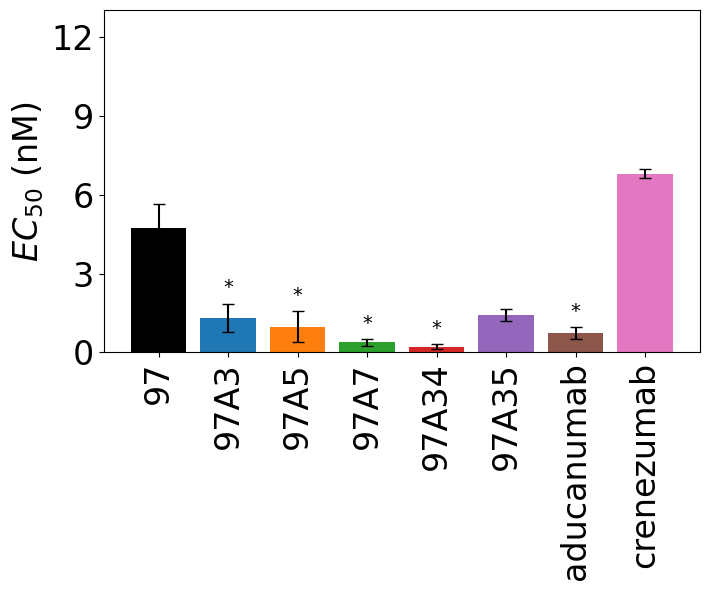

In [17]:
fpath = "/Library/Fonts/Myriad Pro Regular.ttf"
if os.path.exists(fpath):
    prop = fm.FontProperties(fname = fpath, size = 24)
    propg = fm.FontProperties(fname = fpath, size = 14)
else:
    prop = fm.FontProperties(size = 24)
    propg = fm.FontProperties(size = 14)

fig, ax = plt.subplots(figsize=(7.2, 6))
x = np.arange(len(summary))
bars = ax.bar(x, summary['mean'], yerr=summary['std'], capsize=4, color = colors)

ax.set_xticks(x)
ax.set_xticklabels(summary.index, rotation=90, fontproperties = prop)

ax.set_yticks([0, 3, 6, 9, 12])
for tick in ax.get_yticklabels():
    tick.set_fontproperties(prop)
ax.set_ylabel(r'$EC_{50}$ (nM)', fontproperties = prop)

y_max = (summary['mean'] + summary['std']).max()

p_series = pd.Series({lab: pvals.get(lab, float('nan')) for lab in summary.index}, index=summary.index)
p_series.iloc[0] = float('nan')  # don't annotate WT itself (assumes WT is first)

# Add stars above the error bars (μ + std)
annotate_stars(ax, bars, p_series, se=summary['std'], fontprops=propg, pad_frac=0.02)


ax.set_ylim(top=ax.get_ylim()[1] + 0.15 * (y_max - ax.get_ylim()[0]))

plt.tight_layout()
plt.savefig(os.path.join(repo_root, "results", 'Figure-S7.pdf'), transparent = True, dpi = 600)
plt.show()